In [1]:
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
import pandas as pd
import pickle 
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split

# load the DataFrame from a pickle file
df = pd.read_pickle('dataset/processed.pkl')
TRAIN_START_DATE = '2010-01-01'
TRAIN_END_DATE = '2021-01-01'
TRADE_START_DATE = '2021-01-02'
TRADE_END_DATE = '2023-03-26'

In [5]:
INDICATORS = ['macd','rsi_14', 'rsi_21','rsi_28',
 'boll_ub',
 'boll_lb',
 'rsi_30',
 'cci_30',
 'dx_30',
 'close_30_sma',
 'close_60_sma']

In [2]:
import psutil
import ray
ray._private.utils.get_system_memory = lambda: psutil.virtual_memory().total
from ray.tune.registry import register_env

from gymnasium.wrappers import EnvCompatibility

In [3]:
train = data_split(df, TRAIN_START_DATE,TRAIN_END_DATE)
trade = data_split(df, TRADE_START_DATE,TRADE_END_DATE)
print(len(train))
print(len(trade))

72964
23548


In [6]:
stock_dimension = len(train.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 29, State Space: 378


In [7]:
buy_cost_list = sell_cost_list = [0.001] * stock_dimension
num_stock_shares = [0] * stock_dimension

env_kwargs = {
    "hmax": 200,
    "initial_amount": 1000000,
    "num_stock_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4
}

In [8]:
e_trade_gym = StockTradingEnv(df = trade, turbulence_threshold = 70, risk_indicator_col='vix', **env_kwargs)

In [9]:
def env_creator_trading(env_config):
    # env_config is passed as {} and defaults are set here
    df = env_config.get('df', trade)  # changed from the training environment
    
    hmax = env_config.get('hmax', 200)
    initial_amount = env_config.get('initial_amount', 1000000)
    num_stock_shares = env_config.get('num_stock_shares', [0] * stock_dimension)
    buy_cost_pct = env_config.get('buy_cost_pct', buy_cost_list)
    sell_cost_pct = env_config.get('sell_cost_pct', sell_cost_list)
    state_space = env_config.get('state_space', 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension)
    stock_dim = env_config.get('stock_dim', stock_dimension)
    tech_indicator_list = env_config.get('tech_indicator_list', INDICATORS)
    action_space = env_config.get('action_space', stock_dimension)
    reward_scaling = env_config.get('reward_scaling', 1e-4)
    
    # specific for trading
    turbulence_threshold = env_config.get('turbulence_threshold', 70)
    risk_indicator_col = env_config.get('risk_indicator_col', 'vix')

    return EnvCompatibility(StockTradingEnv(
        df=df,
        hmax=hmax,
        initial_amount=initial_amount,
        num_stock_shares=num_stock_shares,
        buy_cost_pct=buy_cost_pct,
        sell_cost_pct=sell_cost_pct,
        state_space=state_space,
        stock_dim=stock_dim,
        tech_indicator_list=tech_indicator_list,
        action_space=action_space,
        reward_scaling=reward_scaling,
        turbulence_threshold=turbulence_threshold,
        risk_indicator_col=risk_indicator_col
    ))

In [10]:
from ray.rllib.agents import ppo
ray.shutdown()

In [11]:
use_ddppo = True


In [12]:
if use_ddppo:
    config = ppo.DDPPOConfig()
else:
    config = ppo.PPOConfig()

# Here set envirnonment parameters if different from default
config = config.environment(
    env_config={'hmax':200, 'initial_amount':1000000}
)

# Training
config = config.training()

# Resources
config = config.resources(
    num_gpus=0,
    num_cpus_per_worker=1,
    num_gpus_per_worker=0,
    num_trainer_workers=2,
    num_gpus_per_trainer_worker = 0,
    num_cpus_per_trainer_worker = 1,
)
# Framework
config = config.framework(
    framework="torch",
)
# Rollouts
config = config.rollouts(
    num_rollout_workers=2,
    num_envs_per_worker=1,
)

# Additional because we are evaluating now
config = config.exploration(
    explore=False
)

print(config)
# pretty(config.to_dict())

In [13]:
# registering the environment to ray
register_env("finrl_trading", env_creator_trading)
# define trainer
if use_ddppo:
    trainer = ppo.DDPPOTrainer(env='finrl_trading', config=config)
else:
    trainer = ppo.PPOTrainer(env='finrl_trading', config=config)

2023-03-27 20:51:15,621	WARNING deprecation.py:50 -- DeprecationWarning: `algo = Algorithm(env='finrl_trading', ...)` has been deprecated. Use `algo = AlgorithmConfig().environment('finrl_trading').build()` instead. This will raise an error in the future!
2023-03-27 20:51:17,811	INFO worker.py:1544 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8266 
(RolloutWorker pid=23668) 2023-03-27 20:51:24,438	WARNING env.py:156 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
(RolloutWorker pid=23668) 2023-03-27 20:51:24,438	WARNING env.py:166 -- Your env reset() method appears to take 'seed' or 'return_info' arguments. Note that these are not yet supported in RLlib. Seeding will take place using 'env.seed()' and the info dict will not be returned from reset.
(RolloutWorker pid=23668) /home/ga_aiot/anaconda3/envs/finrl/lib/python3.8/site-packages/gymnasium/spaces/box.py:227: UserW

In [15]:
# load saved agent
#cwd_checkpoint = f"results/checkpoints/ppo_{total_episodes+1}/checkpoint_0000{total_episodes+1}"
if use_ddppo:
    cwd_checkpoint = 'results/checkpoints/ddppo_51/checkpoint_000051'
#print(f"Restoring from checkpoint {total_episodes+1}")
trainer.restore(cwd_checkpoint)

2023-03-27 20:52:11,261	INFO trainable.py:791 -- Restored on 172.24.68.30 from checkpoint: results/checkpoints/ddppo_51/checkpoint_000051
2023-03-27 20:52:11,262	INFO trainable.py:800 -- Current state after restoring: {'_iteration': 51, '_timesteps_total': None, '_time_total': 461.4647903442383, '_episodes_total': 80}


In [16]:
def DRL_prediction(model, environment):
    """make a prediction"""
    state = environment.reset()
    for i in range(len(environment.df.index.unique())):
        action = model.compute_single_action(state)
        state, reward, done, _ = environment.step(action)
        if i == (len(environment.df.index.unique()) - 2):
            account_memory = environment.save_asset_memory()
            actions_memory = environment.save_action_memory()
        if done:
            print("hit end!")
            break
    print("Test Finished!")
    return account_memory, actions_memory

In [17]:
df_account_value, df_actions = DRL_prediction(
    model=trainer, 
    environment = e_trade_gym)

hit end!
Test Finished!


In [18]:
df_account_value.tail()

,date,account_value
807,2023-03-17,926262.015490
808,2023-03-20,931978.487325
809,2023-03-21,944410.298402
810,2023-03-22,931423.407778
811,2023-03-23,936899.337511


In [19]:
df_actions.head()

,AAPL,AMGN,AXP,BA,CAT,CRM,CSCO,CVX,DIS,GS,...,MRK,MSFT,NKE,PG,TRV,UNH,V,VZ,WBA,WMT
date,,,,,,,,,,,,,,,,,,,,,
2020-01-02,101,200,0,0,0,72,4,0,0,50,...,200,9,0,43,200,0,196,0,179,56
2020-01-03,-101,-96,0,40,0,21,77,0,0,103,...,200,-9,161,-43,15,120,-77,0,-142,-56
2020-01-06,0,-64,0,-31,115,200,101,163,0,200,...,172,178,-161,198,91,104,192,0,-37,0
2020-01-07,0,200,0,-9,-115,135,33,-128,0,-200,...,-40,64,21,44,74,-74,89,76,12,102
2020-01-08,0,200,200,0,164,-103,200,200,0,92,...,6,200,-21,-56,0,-150,156,3,-12,-34


In [23]:
import datetime
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline

print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value)
perf_stats_all = pd.DataFrame(perf_stats_all)
#perf_stats_all.to_csv("./"+RESULTS_DIR+"/perf_stats_all_"+now+'.csv')

==============Get Backtest Results===========
Annual return         -0.020025
Cumulative returns    -0.063101
Annual volatility      0.225955
Sharpe ratio           0.024229
Calmar ratio          -0.061665
Stability              0.031518
Max drawdown          -0.324734
Omega ratio            1.004503
Sortino ratio          0.032458
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.901563
Daily value at risk   -0.028446
dtype: float64


/home/ga_aiot/anaconda3/envs/finrl/lib/python3.8/site-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()


In [25]:
#baseline stats
print("==============Get Baseline Stats===========")
baseline_df = get_baseline(
        ticker="^DJI", 
        start = df_account_value.loc[0,'date'],
        end = df_account_value.loc[len(df_account_value)-1,'date'])

stats = backtest_stats(baseline_df, value_col_name = 'close')

==============Get Baseline Stats===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (811, 8)
Annual return          0.032816
Cumulative returns     0.109506
Annual volatility      0.245947
Sharpe ratio           0.255135
Calmar ratio           0.088486
Stability              0.438359
Max drawdown          -0.370862
Omega ratio            1.052530
Sortino ratio          0.352171
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.954038
Daily value at risk   -0.030737
dtype: float64


/home/ga_aiot/anaconda3/envs/finrl/lib/python3.8/site-packages/finrl/meta/preprocessor/yahoodownloader.py:55: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)
/home/ga_aiot/anaconda3/envs/finrl/lib/python3.8/site-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()
(RolloutWorker pid=10378) /home/ga_aiot/anaconda3/envs/finrl/lib/python3.8/site-packages/gymnasium/spaces/box.py:227: UserWarning: WARN: Casting input x to numpy array.
(RolloutWorker pid=10378)   logger.warn("Casting input x to numpy array.")
(raylet) [2023-03-28 01:10:17,975 E 22376 22376] (raylet) node_manager.cc:3040: 1 Workers (tasks / actors) killed due to memory pressure (OOM), 0 Workers crashed due to other reasons at node (ID: 4228e5a7

==============Compare to DJIA===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (811, 8)


/home/ga_aiot/anaconda3/envs/finrl/lib/python3.8/site-packages/finrl/meta/preprocessor/yahoodownloader.py:55: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)
/home/ga_aiot/anaconda3/envs/finrl/lib/python3.8/site-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()
/home/ga_aiot/anaconda3/envs/finrl/lib/python3.8/site-packages/pyfolio/plotting.py:648: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for stat, value in perf_stats[column].iteritems():


Start date,2020-01-02
End date,2023-03-23
Total months,38
,Backtest
Annual return,-2.002%
Cumulative returns,-6.31%
Annual volatility,22.595%
Sharpe ratio,0.02
Calmar ratio,-0.06
Stability,0.03
Max drawdown,-32.473%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,32.47,2020-02-12,2020-03-23,2020-12-04,213
1,24.17,2021-07-26,2022-09-30,NaT,NaN
2,6.14,2020-12-31,2021-01-29,2021-02-24,40
3,5.68,2021-03-12,2021-06-18,2021-07-26,97
4,3.67,2021-02-24,2021-02-26,2021-03-09,10


/home/ga_aiot/anaconda3/envs/finrl/lib/python3.8/site-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])
/home/ga_aiot/anaconda3/envs/finrl/lib/python3.8/site-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])
/home/ga_aiot/anaconda3/envs/finrl/lib/python3.8/site-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])
/home/ga_aiot/anaconda3/envs/finrl/lib/python3.8/site-packages/pyfolio/timeseries.py:541: FutureWarning: The default dtype for empty Series will be 'ob

Stress Events,mean,min,max
New Normal,0.00%,-9.68%,8.06%


/home/ga_aiot/anaconda3/envs/finrl/lib/python3.8/site-packages/pyfolio/timeseries.py:1230: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  period = returns_dupe.loc[start:end]


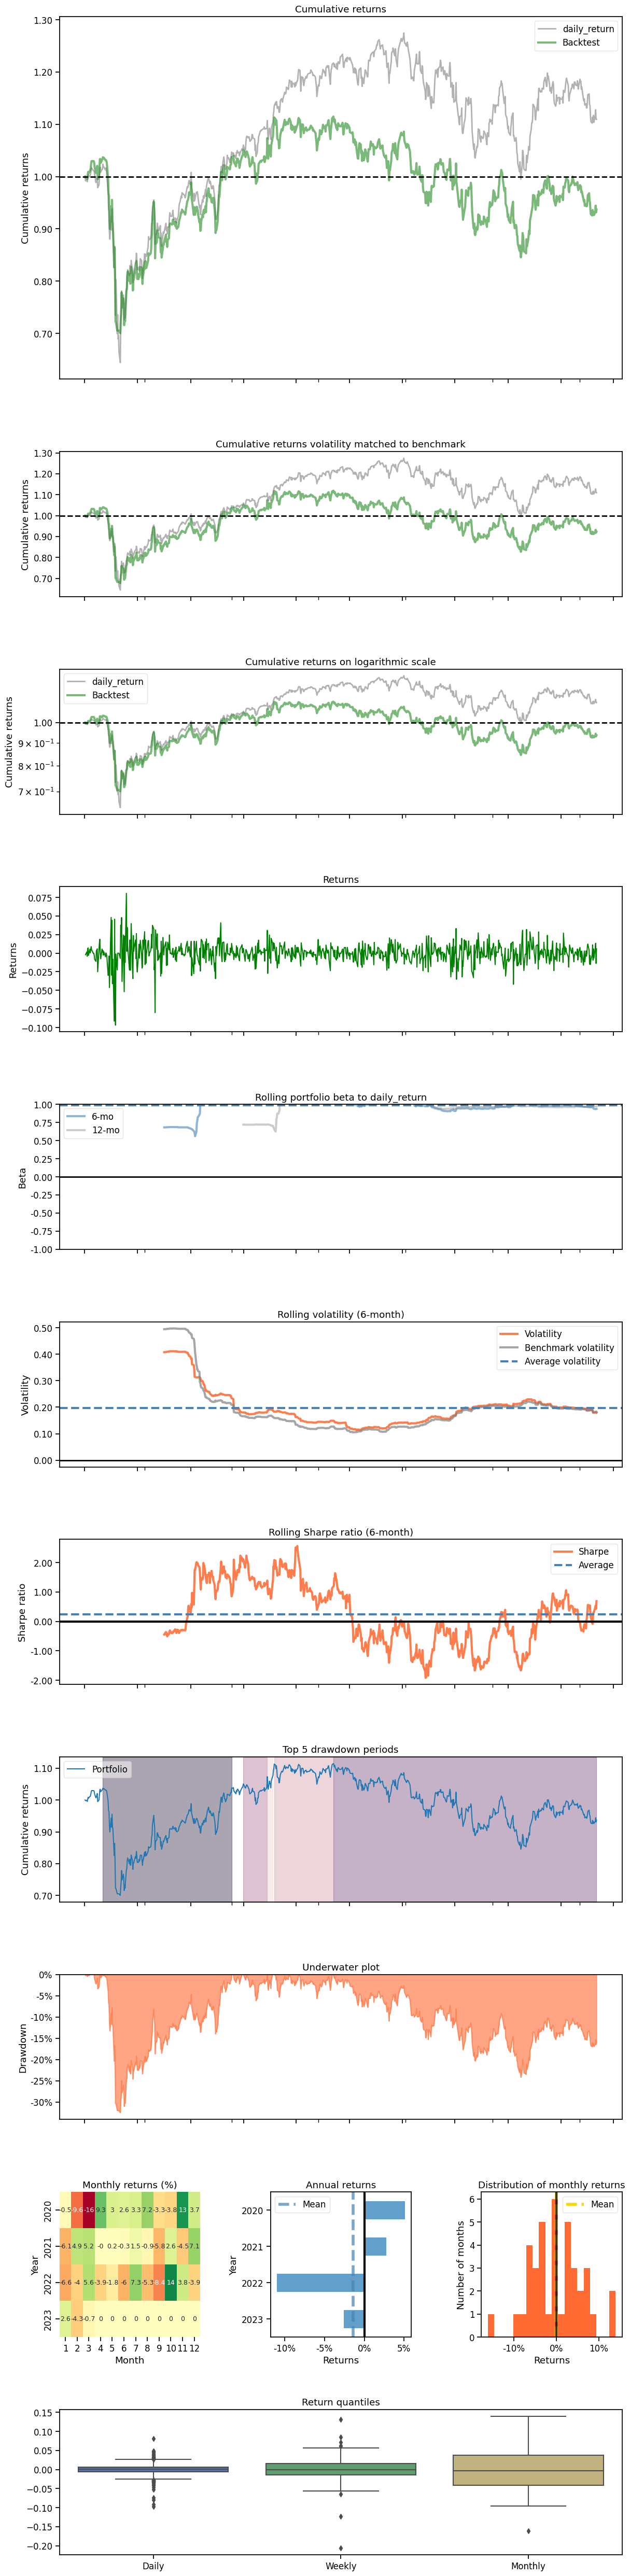

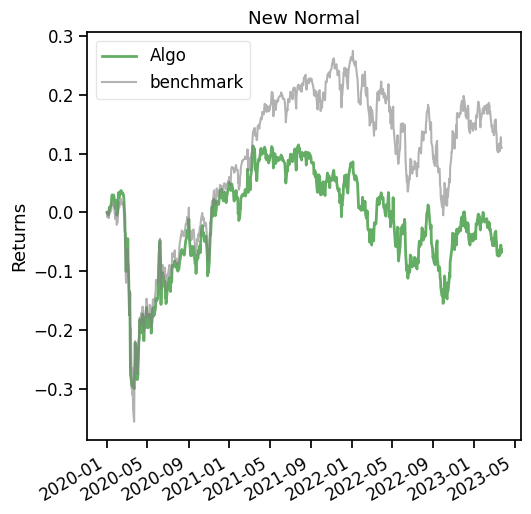

In [24]:
print("==============Compare to DJIA===========")
%matplotlib inline
# S&P 500: ^GSPC
# Dow Jones Index: ^DJI
# NASDAQ 100: ^NDX
backtest_plot(df_account_value, 
             baseline_ticker = '^DJI', 
             baseline_start = df_account_value.loc[0,'date'],
             baseline_end = df_account_value.loc[len(df_account_value)-1,'date'])